# Collaborative Filtering of Movies
## MSDS 7349 - Section 401
## Project 3

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Import Dataset](#Import)
* [Business Understanding](#Business-Understanding)
* [Data Understanding](#Data-Understanding)
* [Modeling and Evaluation](#Modeling-and-Evaluation)
* [Deployment](#Deployment)
* [Exceptional Work](#Exceptional-Work)
* [References](#References)

# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)
* [Kevin Cannon](https://github.com/kcannon2)
* [Ernesto Carrera Ruvalcaba](https://github.com/ecarrerasmu)
* [Adam Tschannen](https://github.com/adamtschannen)

# <a name="Import"></a>Import Dataset

In [3]:
%%capture
# Sources:
# https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
# Supress output - https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
# https://acodeforthought.wordpress.com/2016/12/26/building-a-simple-recommender-system-with-movie-lens-data-set/
import graphlab as gl
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd

filepath = '../data/ml-100k/ratings.csv'
dataCols = ['user_id', 'movie_id', 'rating', 'timestamp']
itemCols = ['movie_id', 'movie_title', 'release_date', 
            'video_release_date', 'IMDB_URL', 'unknown', 
            'action', 'adventure', 'animation', 'childrens',
            'comedy', 'crime', 'documentary', 'drama',
            'fantasy', 'film-noir', 'horror', 'musical',
            'mystery', 'romance', 'sci_fi', 'thriller',
            'war', 'western'          
           ]
userCols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

data = pd.read_csv('../data/ml-100k/u.data', sep = '\t', names = dataCols, encoding = 'latin-1')
item = pd.read_csv('../data/ml-100k/u.item', sep = '|', names = itemCols, encoding = 'latin-1')
user = pd.read_csv('../data/ml-100k/u.user', sep = '|', names = userCols, encoding = 'latin-1')

dataP = pd.merge(pd.merge(item, data), user)
dataP.to_csv('../data/pandas_dataframe.csv', encoding='latin-1')
dataS = gl.SFrame.read_csv('../data/pandas_dataframe.csv')



# <a name="Business-Understanding"></a>Business Understanding
*[10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

![xkcd: Machine Learning](../images/machine_learning.png)

* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)

> GroupLens is a research lab based out of the University of Minnesota's Department of Computer Science and Engineering. Part of the research lab's focus is in recommender systems. Consequently, GroupLens Research has collected this movie data because they offer a movie recommendation service while providing providing open-source data to the public for free. This dataset was found by our team in a Github Repository compiling publicly available datasets for recommender systems and machine learning. Afterwards we realized the very same dataset is endorsed in the syllabus as a good dataset to use for project 3. At first glance the data looked clean, offered variable sizing depending on the scope of the project, so we decided to proceed with utilizing GroupLens' data. 

* How will you measure the effectiveness of a good algorithm?

> The effectiveness of a good algorithm produced by this project will be measured with cross validation and evaluated in three ways; with Root Mean Squared Error (RMSE), per-user-recall, and per-user-precision.

> The first step in evaluating our algorithm via RMSE will be to calculate the average RMSE of every entry in the dataset using the following equation:

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

> Afterwards, the RMSE for each user in the dataset will be calculated via:

$$\underbrace{RMSE(U)}_{\text{user=U}}=\sqrt{\frac{1}{|U|}\sum_{u\in U} (\hat{y}_u-y_u)^2}$$

> Additionally, the RMSE for each movie in the dataset will be calculated via:

$$\underbrace{RMSE(M)}_{\text{movie=M}}=\sqrt{\frac{1}{|M|}\sum_{m\in M} (\hat{y}_m-y_m)^2}$$

> The per-user-recall will be measured with the following equation:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

> Wherein $p_k$ is a vector of the $k$ highest ranked recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

> The per-user-precision will be measured with the following equation:

$$P(k)=\frac{|a \cap p_k|}{k} $$

> Wherein $p_k$ is a vector of the $k$ recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

* Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

> Potential vehicles in which to validate a given model are A/B testing, Root Mean Squared Error, recall, and precision. A/B testing is not feasible for this project because there is no way to test the model in a live setting. In other words, statistical hypothesis testing via click-rate and response rate cannot be measured in a real-word system because we are not privy to such an application. Fortunately, A/B testing is not the only way to evaluate a recommender system's quality.

> Root Mean Squared Error is one of the most commonly used methods to evaluate a recommender system. RMSE makes sense for the GroupLens movie ratings data because it was specifically collected with recommender systems in mind. In other words, the predicted movie recommendations will be compared to the actual movie recommendations. The GroupLens data even contains their own file of compiled recommendations with which one can carry out comparisons. By measuring general, per-user, and per-movie RMSE we will be able to discern the quality of a given model on a more granular level. Moreover, visualizing the array of averages produced by per-user and per-movie RMSE will provide a general macro overview of a given model. Additionally, statistical tests will be performed to comparatively evaluate models based on their respect RMSE values.

> Recall evaluation does have some limitations as not every user is going to rate all movies they watch. Most likely, users will only rate movies for which they have strong positive or negative feelings. However, per-user-recall is still relevant to the stakeholders needs as it us to answer the following question of interest: "of all the items rated positively by the user, how many did your recommender find?"

> By the same token, the limitations of precision evaluation are the same as those of recall evaluation. Fortunately, per-user-precision still makes sense for validating models for this specific dataset, and is still relevant to the stakeholders needs, because it allows us to answer the following question of interest:"of the k items found by your recommender, how many were rated positively by the user?"

> Much like per-user RMSE, statistical hypothesis tests will be used to for both recall and precision evaluation to comparatively discern the best performing models produced by in this project.

# <a name="Data-Understanding"></a>Data Understanding
*[10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems?*

* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file

| Variable | Variable Type | Description |
| :------: | :-----------: | :---------: |
| userId | int | ID associated with a given user. Users were selected at random for inclusion and IDS have been anonymized.<br/>All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. |
| movieId | int | ID associated with a given movie.<br/> The Movie IDs all contain "at least one rating or tag are included in the dataset"|
| rating | int | Ratings are made on a zero to 5-star scale, with half-star increments (0.5 stars - 5.0 stars).|
| timestamp | int | Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. |
| title | str | Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses.<br/> Errors and inconsistencies may exist in these titles. |
| genres | str| Genres are a pipe-separated list as a string, and are selected from the following:<br/>Action<br/>Adventure<br/>Animation<br/>Children's<br/>Comedy<br/>Crime<br/>Documentary<br/>Drama<br/>Fantasy<br/>Film-Noir<br/>Horror<br/>Musical<br/>Mystery<br/>Romance<br/>Sci-Fi<br/>Thriller<br/>War<br/>Western<br/>(no genres listed) |

>"This dataset (ml-20m) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

>Users were selected at random for inclusion and IDS have been anonymized. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided."

>The Movie IDs all contain "at least one rating or tag are included in the dataset."

>The genres of movie are: Action,	Animation,	Comedy,	Drama,	Documentary, and Romance Short.

> As seen below, a call to the shape function verifies the number of observations, as well as attributes within the dataset:

In [6]:
dataP.shape

(100000, 31)

> Moreover, the summary statistics for each non-categorical variable are found below:

In [7]:
dataP.describe()

,movie_id,video_release_date,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,mystery,romance,sci_fi,thriller,war,western,user_id,rating,timestamp,age
count,100000.000000,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,1.000000e+05,100000.000000
mean,425.530130,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,...,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,462.48475,3.529860,8.835289e+08,32.969850
std,330.798356,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,...,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,266.61442,1.125674,5.343856e+06,11.562623
min,1.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.00000,1.000000,8.747247e+08,7.000000
25%,175.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,254.00000,3.000000,8.794487e+08,24.000000
50%,322.000000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,447.00000,4.000000,8.828269e+08,30.000000
75%,631.000000,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,682.00000,4.000000,8.882600e+08,40.000000
max,1682.000000,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,943.00000,5.000000,8.932866e+08,73.000000


> Below one can see a brief snapshot of how the dataset appears:

In [8]:
dataP.head()

,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown,action,adventure,animation,childrens,...,thriller,war,western,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,308,5,887736696,60,M,retired,95076


* Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [9]:
dataP.isnull().sum()

movie_id                   0
movie_title                0
release_date               9
video_release_date    100000
IMDB_URL                  13
unknown                    0
action                     0
adventure                  0
animation                  0
childrens                  0
comedy                     0
crime                      0
documentary                0
drama                      0
fantasy                    0
film-noir                  0
horror                     0
musical                    0
mystery                    0
romance                    0
sci_fi                     0
thriller                   0
war                        0
western                    0
user_id                    0
rating                     0
timestamp                  0
age                        0
gender                     0
occupation                 0
zip_code                   0
dtype: int64

In [10]:
# Source:
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
dataP.isnull().values.any()

True

> The two above cells of code verifies there are missing or null values. Specifically, there are 9 null values for movie release date, 100,000 null values for video release date, and 13 null values for a given movie's IMDB URL link. However, these attributes are likely to be insignificant with regards to constructing a collaborative filtering recommender system. Now let's check if there exists any duplicate data:

In [11]:
# Source:
# https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
import pandas as pd
dataP.duplicated().sum()

0

> Fortunately, there are no duplicated values within the dataset. Now let's check for outliers:

In [12]:
dataS.show()

Canvas is accessible via web browser at the URL: http://localhost:57287/index.html
Opening Canvas in default web browser.


In [9]:
import seaborn as sns
ax = sns.violinplot(x='movieId', y='rating', data=dataP, split=True)

ValueError: object too deep for desired array

In [10]:
sum(dataP['rating'] == -1)

0

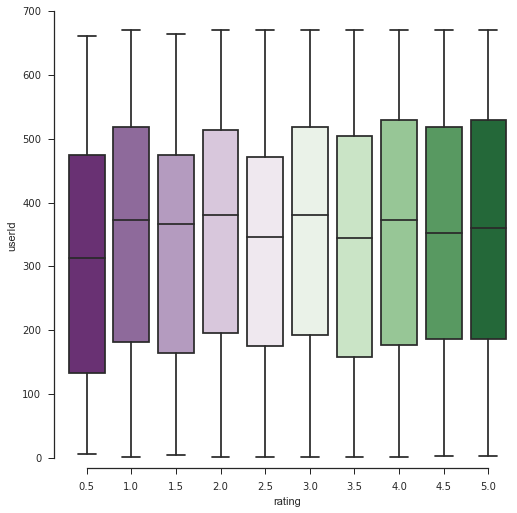

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(x="rating", y="userId", data=dataP, palette="PRGn")
sns.despine(offset=10, trim=True)
plt.figure(figsize=(40,1000))

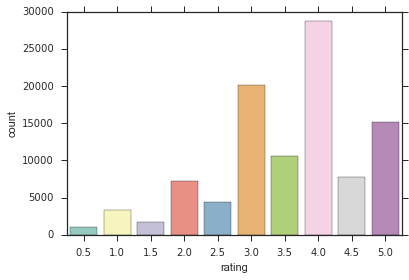

In [12]:
import seaborn as sns
ax = sns.countplot(x="rating", data=dataP, palette="Set3")

In [14]:
dataP.columns

Index([u'userId', u'movieId', u'rating', u'timestamp', u'title', u'genres'], dtype='object')

In [20]:
pd.get_dummies(dataP['genres']).columns

Index([u'(no genres listed)', u'Action', u'Action|Adventure',
       u'Action|Adventure|Animation', u'Action|Adventure|Animation|Children',
       u'Action|Adventure|Animation|Children|Comedy',
       u'Action|Adventure|Animation|Children|Comedy|Fantasy',
       u'Action|Adventure|Animation|Children|Comedy|IMAX',
       u'Action|Adventure|Animation|Children|Comedy|Romance',
       u'Action|Adventure|Animation|Children|Comedy|Sci-Fi',
       ...
       u'Romance|Thriller', u'Romance|War', u'Romance|Western', u'Sci-Fi',
       u'Sci-Fi|IMAX', u'Sci-Fi|Thriller', u'Sci-Fi|Thriller|IMAX',
       u'Thriller', u'War', u'Western'],
      dtype='object', length=901)

In [17]:
dataP.columns

Index([u'userId', u'movieId', u'rating', u'timestamp', u'title', u'genres'], dtype='object')

*[10 points] Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.*

In [ ]:
# Ernesto insert work here

### Visualizing important attributes

> The command "show" in Turi (excecuted below) automatically generates a graphical interface to visualize the data in an independent window browser. It is divided into 3 sections: "Summary", "Table", and "Plots". The "Summary" section shows the basic statistics of the variable. For the numeric variables, it creates box-whisker plots whereas for the categorical variables it generates a horizontal histogram displaying the label of the most frequent items. The "Table" part allows the user to easily navigate through the records of the dataset. Lastly, the component "Plots" enables the analysis of the relationship between 2 variables by generating customized charts. The user can plot the 2 variables using box-whisker, line chart, and a heat map.

>Looking into the first section "Summary", the description of the 6 variables in the dataset is as follows:

>1) userID: There are 669 unique users in our dataset. The total number of records is 100,004.

>2) movieID: The number of distinct movies is of 9,061.

>3) rating: This variable only takes 6 values, the integers from 0 to 5. The higher the rating the better the movie.

>4) timestamp: The different values for the dates is of 77,900.

>5) Title: There are 9,065 different titles in the dataset. The top 3 of the movies with the highest number of ratings are Forrest Gump, Pulp Fiction, and Shawshank.

>6) Genre: The movies can fall into different ranges. For example, a movie can be categorized as "Comedy and Romance". 

>The top 3 most frequent genres are: "Drama", "Comedy", and "Comedy & Romance". The total number of different combinations of genres is 904.

>Lastly, in section "Plots", the distribution of the rating indicates that the ratings are primarily concentrated in the grades of "3" and "4" and less concentrated in values of "0"

In [ ]:
data.show()

In [ ]:
data.shape

# <a name="Modeling-and-Evaluation"></a>Modeling and Evaluation
*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by:*

## [10 Points] Train and adjust parameters

# User-Item Recommendation System

In [ ]:
data.head()

In [ ]:
import graphlab as gl
model = gl.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

In [ ]:
results # the recommendation output

In [ ]:
data.head()

## Item-Item Recommendation System

In [ ]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

In [ ]:
train, test = gl.recommender.util.random_split_by_user(data,
                                                    user_id="userId", item_id="movieId",
                                                    max_num_users=100, item_test_proportion=0.2, random_seed=1)

In [ ]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

In [ ]:
print rmse_results.viewkeys()

In [ ]:
rmse_results['rmse_by_user']

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']>50]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

In [ ]:
rmse_results['precision_recall_by_user']

## Cross Validated Collaborative Filtering

In [ ]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

In [ ]:
import graphlab.aggregate as agg
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

In [ ]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

## [10 Points] Evaluate and Compare

In [ ]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

In [ ]:
comparisonstruct = gl.compare(test,[item_item, rec1])

In [ ]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

In [ ]:
%%capture
params = {'user_id': 'userId', 
          'item_id': 'movieId', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=5,
        environment=None)

In [ ]:
job.get_status()

In [ ]:
job_result = job.get_results()

job_result.head()

In [ ]:
models = job.get_models()
models

In [ ]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

## [10 Points] Visualize Results

## [20 Points] Summarize the Ramifications

Some of the general ramifications of using a recommender system is popular movies stay popular. For instance, if one movie has a lot of five star ratings, it is more likely to be recommend than a movie with 0 star ratings. This leads us to our next ramification; new movies will not be recommended.  If a new movie gets added to the list without any ratings, it will not likely be recommended based on the rating system. Because of this, the likeliness of a niche movies or a popular movies will likely be static. 

# <a name="Deployment"></a>Deployment
*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
* How would your deploy your model for interested parties?
* What other data should be collected?
* How often would the model need to be updated, etc.?

In [ ]:
# Kevin insert work here

# <a name="Exceptional-Work"></a>Exceptional Work
*You have free reign to provide additional analyses or combine analyses.*

1. data set with 20m+ rows
2. training and testing with two completely different data sets
3. grid search 

# <a name="References"></a>References

* https://github.com/msds7331/classification-project2/blob/master/notebooks/project2-report.ipynb
* https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
* https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
* https://grouplens.org/datasets/movielens/
* https://xkcd.com/1838/
* https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
* https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
* https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html

In [ ]:
# Correlation heat map matrix
# Source:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd

# Source:
# https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
data_pandas = data.to_dataframe()
corr = data_pandas.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    movie_heatmap_corr = sns.heatmap(data_pandas, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline

dataPandas = data.to_dataframe()

# calculate the correlation matrix
corr_matrix  = dataPandas.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(180,360)) 
sns.set(font_scale=8)
sns.heatmap(upper[to_drop] , linewidths=.15, ax=ax)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline
#dtype={'rating':int}
filepath = '../data/ml-latest-small/ratings.csv';
ratingsP = pd.read_csv(filepath)
moviesP = pd.read_csv('../data/ml-latest-small/movies.csv')
dataP = ratingsP.merge(moviesP, on='movieId', how='left')
dataP.head()

In [ ]:
corr = dataP.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    movie_heatmap_corr = sns.heatmap(dataP, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")

In [ ]:
dataP['rating'].dtype

In [ ]:
# calculate the correlation matrix
corr_matrix  = dataP.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(180,360)) 
sns.set(font_scale=8)
sns.heatmap(upper[to_drop] , linewidths=.15, ax=ax)